In [16]:
import pm4py
pm4py.__version__

'1.3.0'

# Performance Analysis

> Which parts of the process have the biggest influence on the total case duration?

## Data loading

Import the log.

In [17]:
import os
import pandas as pd
from pm4py.objects.log.importer.xes import factory as xes_import_factory
from pm4py.objects.petri.importer import factory as pnml_importer

PROJ_ROOT = os.path.abspath(os.path.pardir)
data_path = os.path.join(PROJ_ROOT, 'data', 'log.csv')

assert os.path.exists(data_path)

# load csv
df_log = pd.read_csv(data_path)

# convert timestamp columns to datetime friendly format
df_log['Timestamp'] = pd.to_datetime(df_log['Timestamp'])
df_log['start_timestamp'] = pd.to_datetime(df_log['start_timestamp'])

#import the renamed event log from Q1
event_log = xes_import_factory.apply(PROJ_ROOT+"/data/processed_log.xes")

#import the filtered petri net obtained in Q1
pnml_path = os.path.join(PROJ_ROOT, 'results', 'Q1', 'filtered_petri.pnml')
net, initial_marking, final_marking = pnml_importer.apply(pnml_path)

C:\Users\Sezin\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use importer entrypoint instead
C:\Users\Sezin\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use importer module instead.


In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# set default plot size
plt.rcParams['figure.figsize'] = (15, 10)

---

# a)
> Provide and briefly describe results of your performance analysis. Remember to also consider your current results which may give you a good entry point for a deeper analysis.

### Activities duration

We start our exploration of the process performance by evaluating the performance of single activities. At first we visualize the activities duration. The results can be found below.

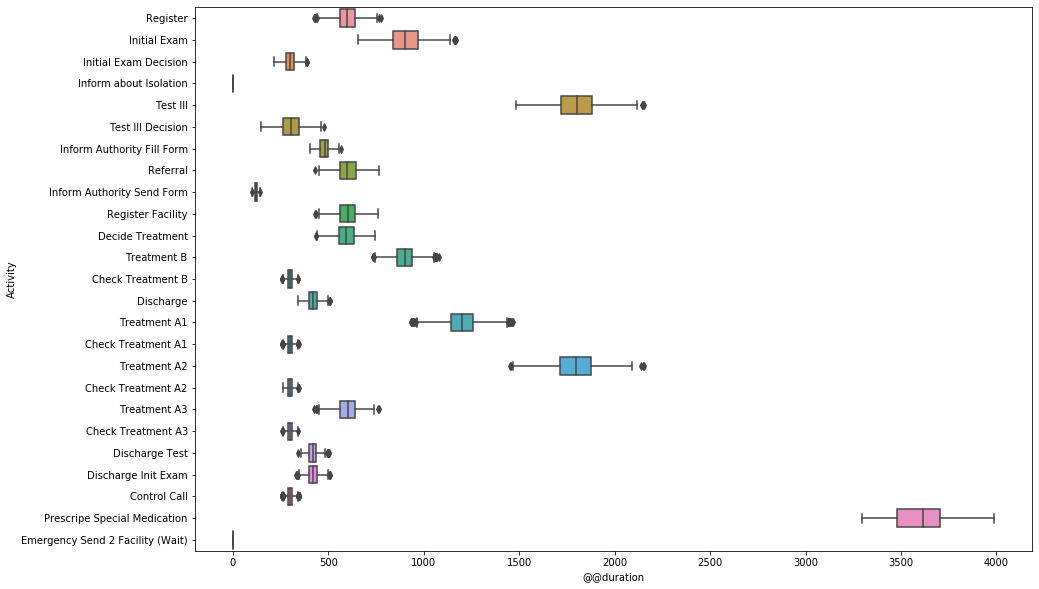

In [19]:
sns.boxplot(data=df_log, y='Activity', x='@@duration', orient='h')
plt.show()

What we can observe here is that the _Prescripe Special Medication_ activity has by far the largest average duration. Also, _Test III_ has the second largest average duration.

Administrative tasks like registration activities also show a long duration, while examination decisions and treatment checks have the shortest duration.

All of the standard deviations are small considering the overall duration of the activities, this means that there is not much variation in the time that is required for a specific activity in between cases. We also notice that there is no presence of anomalies in the distributions, all of them seem very close to a normal distribution.

In general we see that the activities related to treatments have long durations, we can take a closer look.

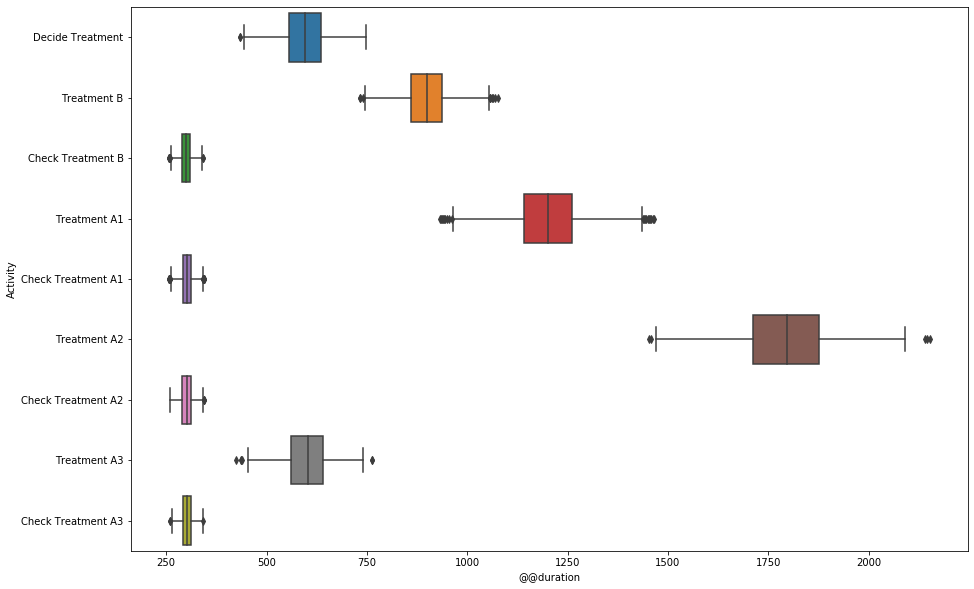

In [20]:
sns.boxplot(data=df_log[df_log['Activity'].str.contains('Treatment')], y='Activity', x='@@duration', orient='h')
plt.show()

We see that _Treatment A2_ has the largest average duration, but knowing that this activities are performed many times in a single process, it is useful to evaluate their summed duration.

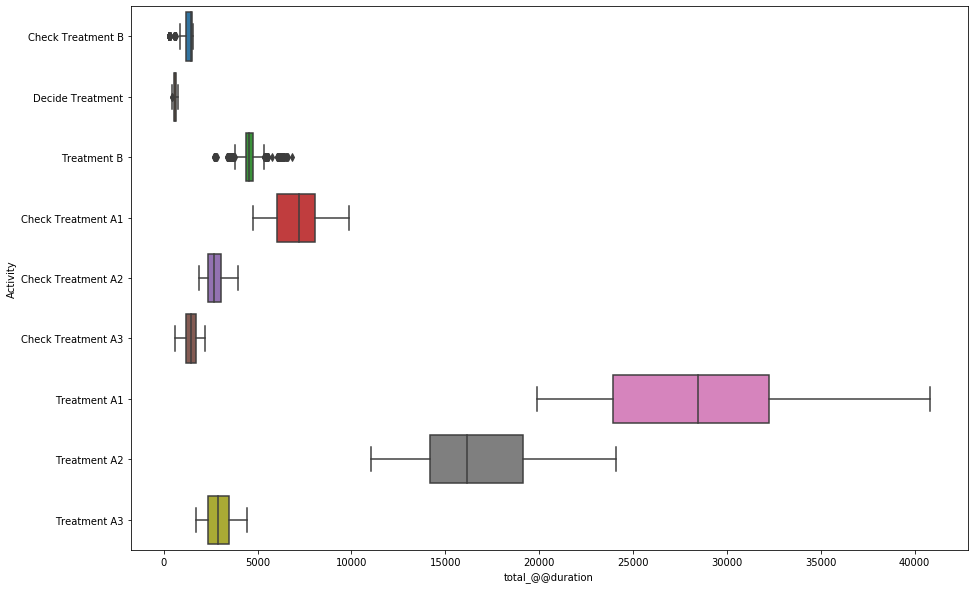

In [21]:
df_activities_duration = (df_log.groupby(['Patient', 'Activity'])['@@duration'].sum()
                                .reset_index().rename({'@@duration': 'total_@@duration'}, axis='columns'))
df_treatment_durations = df_activities_duration[df_activities_duration['Activity'].str.contains('Treatment')]

sns.boxplot(data=df_treatment_durations, y='Activity', x='total_@@duration', orient='h')
plt.show()

So we see that even though _Treatment A2_ has the biggest average duration, it is not the one with the largest total duration (taking on account all the times it was executed) in a process, this being _Treatment A1_.

We can also notice that when we are dealing with the total duration of the activities, the values become bigger by one order of magnitude, which makes us interested in the total duration of the remaining activities.

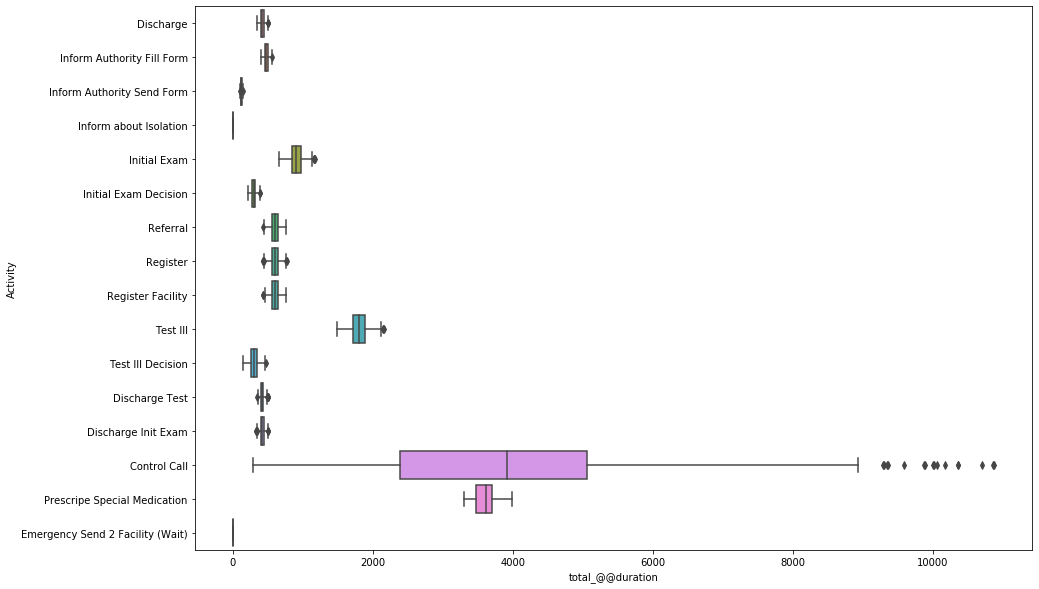

In [22]:
df_ = df_activities_duration[~df_activities_duration['Activity'].str.contains('Treatment')]

sns.boxplot(data=df_, y='Activity', x='total_@@duration', orient='h')
plt.show()

This way we can see that the _Control Call_ activity is actually more time demanding than we have estimated by the previous analysis.

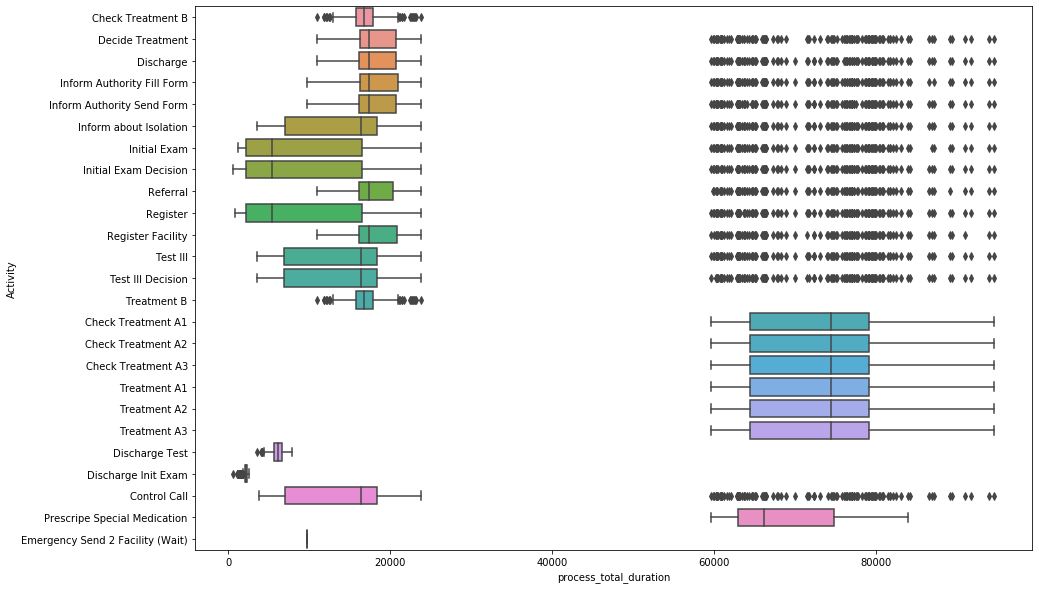

In [23]:
total_process_duration = df_log.groupby('Patient')['@@duration'].sum()
df_activities_duration['process_total_duration'] = df_activities_duration['Patient'].map(total_process_duration)

sns.boxplot(data=df_activities_duration, y='Activity', x='process_total_duration')
plt.show()

Comparing the activities with the total process duration in which they are present, we see that the Treatments A1, A2 and A3 correlate to much longer processes.

---

# b)
> Discuss insights obtained from you analysis, for example identify bottlenecks, and discuss their impact.

### Process length

We could notice in the previous graph a hint that the processes can be divided in two groups regarding their length, let's take a deeper look into that.

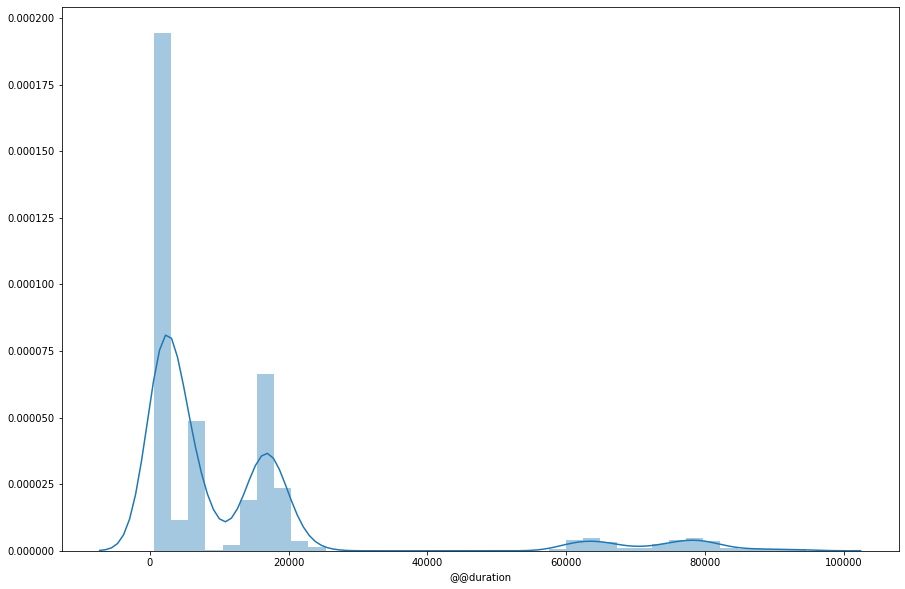

In [24]:
sns.distplot(total_process_duration)
plt.show()

We notice roughly two groups here, separated by the 40000 seconds duration mark.

Let's investigate further if this is also reflected in the lead time of the processes.

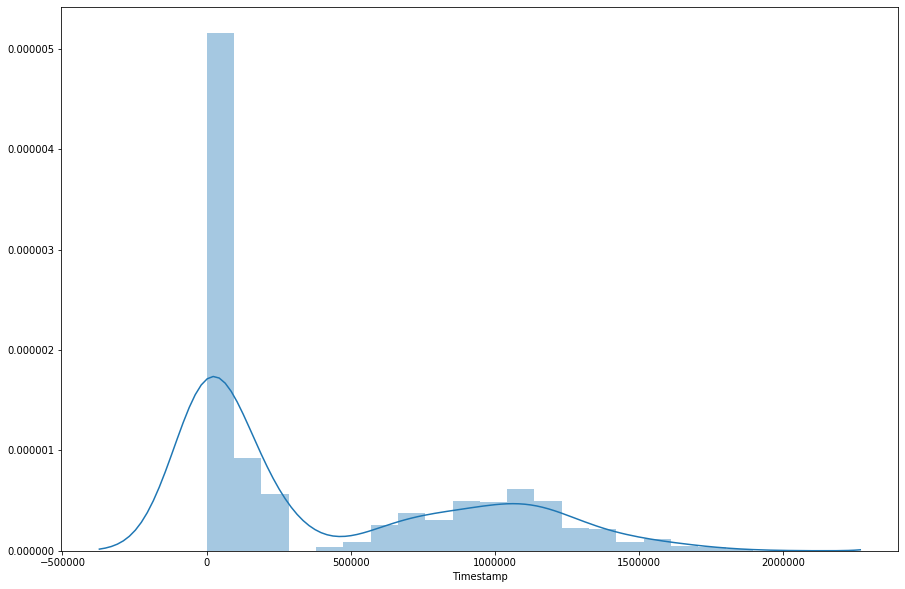

In [25]:
lead_time = df_log.groupby('Patient')['Timestamp'].max() - \
            df_log.groupby('Patient')['Timestamp'].min()

sns.distplot(lead_time.apply(lambda t: t.total_seconds()), bins=20)
plt.show()

Again we see that the lead time has two groupings, split around 370000 seconds.

We can search for the causes of this difference by seeing it as a classification problem being the features the presence of the activities. This way, the most influential features as the main causes for the lead time.

In [28]:
from pm4py.objects.log.util import get_log_representation, get_class_representation

data, feature_names = get_log_representation.get_representation(
    log=event_log,
    str_tr_attr=[],
    str_ev_attr=['Activity'],
    num_tr_attr=[],
    num_ev_attr=[]
)
target, classes = get_class_representation.get_class_representation_by_trace_duration(event_log, target_trace_duration=370000, timestamp_key='Timestamp')

from sklearn.tree import DecisionTreeClassifier

# limit DT depth to get a simpler representation, with the main approaches
clf = DecisionTreeClassifier(min_samples_leaf=5)
# clf = DecisionTreeClassifier(min_samples_leaf=15)
clf = clf.fit(data, target)

from pm4py.visualization.decisiontree import factory as dt_visualizer

dt_vis = dt_visualizer.apply(clf, feature_names, classes)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')
dt_vis.render(os.path.join(figures_dir, 'q3_decision_tree'),
              #format='pdf',
              view=True)

C:\Users\Sezin\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.


'F:\\uni\\APM\\APM-A1\\report\\figures\\q3_decision_tree.png'

We can see that the major cause for the long lead time of the processes is the happening of `Inform Authority Send Form`, which means that the patient will be forwarded to treatment, therefore taking longer time under observation.

In [30]:
from pm4py.visualization.petrinet import factory as pn_visualizer
from pm4py.algo.discovery.inductive import factory as inductive_miner
from pm4py.util import constants

# map dataset columns to PM4Py keys
param_keys={constants.PARAMETER_CONSTANT_CASEID_KEY: 'Patient',
            constants.PARAMETER_CONSTANT_RESOURCE_KEY: 'Resource', 
            constants.PARAMETER_CONSTANT_ACTIVITY_KEY: 'Activity',
            constants.PARAMETER_CONSTANT_TIMESTAMP_KEY: 'Timestamp',
            constants.PARAMETER_CONSTANT_START_TIMESTAMP_KEY: 'start_timestamp'}

#annotate the mined petri net with performance measures
perf_net_vis = pn_visualizer.apply(net, initial_marking, final_marking=final_marking,
                                   variant=pn_visualizer.PERFORMANCE_DECORATION,
                                   log=event_log, parameters=param_keys)

figures_dir = os.path.join(PROJ_ROOT, 'report', 'figures')

# fix place size
import numpy as np
body = np.array(perf_net_vis.body)
body[body ==  '\tnode [fixedsize=true shape=circle width=0.75]'] = '\tnode [fixedsize=true shape=circle width=1]'
perf_net_vis.body = body

perf_net_vis.render(os.path.join(figures_dir, 'q3_perf_petrinet'),
                 #format='pdf',
                 view=True)

C:\Users\Sezin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecatedWarning: apply is deprecated as of 1.3.0 and will be removed in 2.0.0. Use visualizer module instead.
  from ipykernel import kernelapp as app


'F:\\uni\\APM\\APM-A1\\report\\figures\\q3_perf_petrinet.png'

We have annotated the petri net that was obtained in Q1 after preprocessing the log with a performance metric. The metric used is the mean time between two events.

<h2 style="color:red">TODO: analysis on the annotated petri net.</h2>

### Components

We can also visualize if the components (as discussed in Q2) have any impact in the performance of the processes.

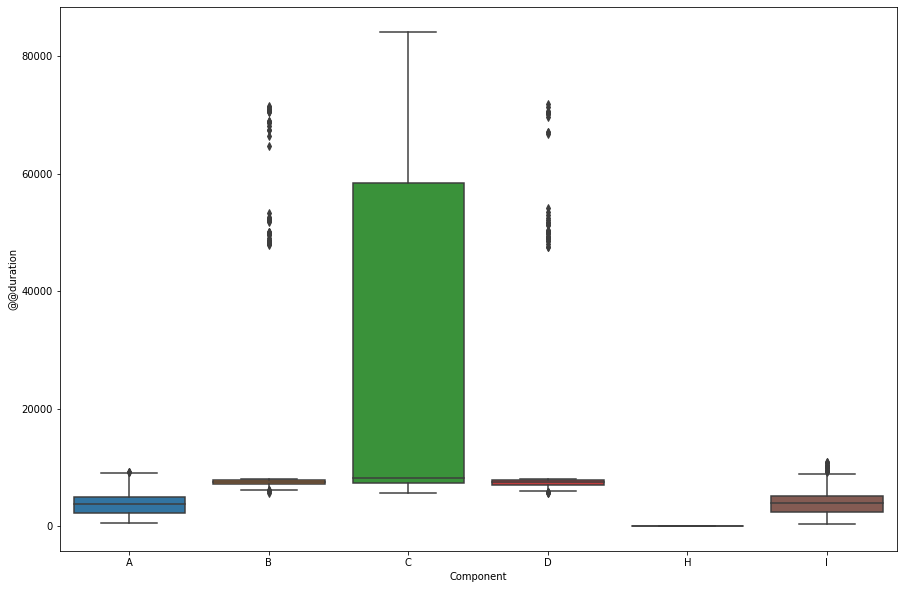

In [31]:
df_log['Component'] = df_log['Resource'].str[0]

df_components = df_log.groupby(['Component', 'Patient'])['@@duration'].sum().reset_index()

sns.boxplot(data=df_components, x='Component', y='@@duration')
plt.show()

We see that the component C is presenting longer processes duration for the activities than their counterparts B and D, which perform similar activities.

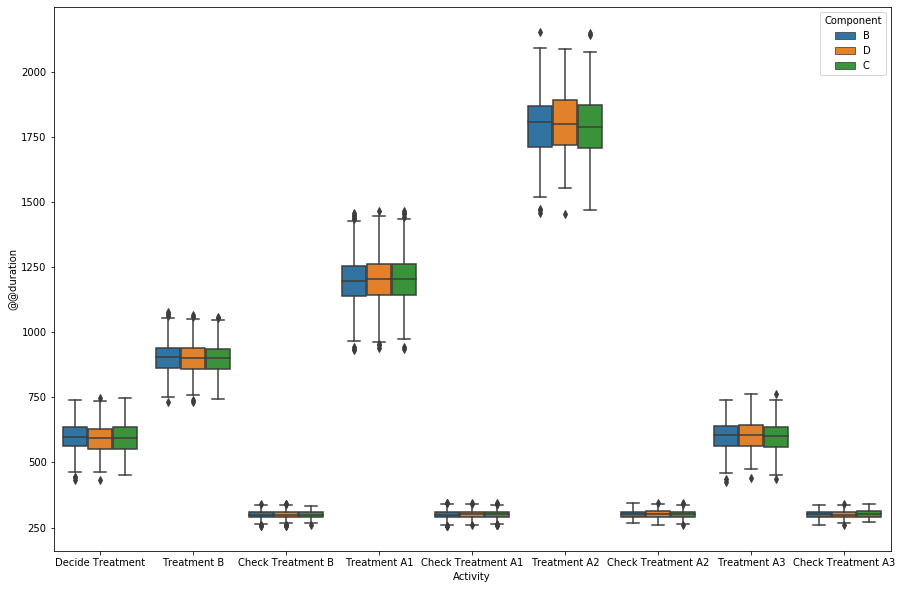

In [32]:
df_treatment = df_log[(df_log['Component'].isin(['B', 'C', 'D'])) & \
                      (df_log['Activity'].str.contains('Treatment'))]

sns.boxplot(data=df_treatment, x='Activity', y='@@duration', hue='Component')
plt.show()

We see no difference in the performance of the activities comparing the three components that deal with the treatments. Therefore, we can estimate that the difference is in the amount of activities performed in the processes related to component C.

In [33]:
activities_per_component = df_log.groupby('Component')['Activity'].count()
patients_per_component = df_log.groupby('Component')['Patient'].nunique()

activities_per_component / patients_per_component

Component
A     6.098000
B    26.870647
C    30.912752
D    23.308824
H     1.000000
I    13.062992
dtype: float64

We confirm our idea that the component C performs more tasks for each related process, having an average of 31 activities per process (in which it actuates).

### Age

We can also inspect if the age of the patients has any influence on the performance.

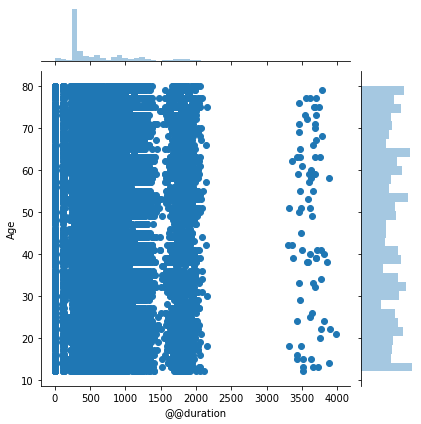

In [34]:
sns.jointplot(data=df_log, x='@@duration', y='Age')
plt.show()

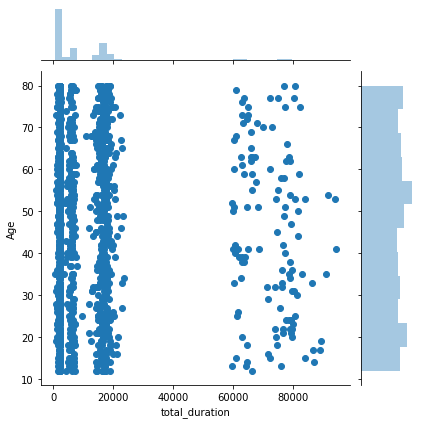

In [35]:
df_ = pd.DataFrame(total_process_duration).rename({'@@duration':'total_duration'}, axis='columns')
df_['Age'] = df_log.groupby('Patient')['Age'].first()

sns.jointplot(data=df_, x='total_duration', y='Age')
plt.show()

So we see that neither the duration of the individual activities nor the total duration of the process are related to the age of the patients.

### Insurance

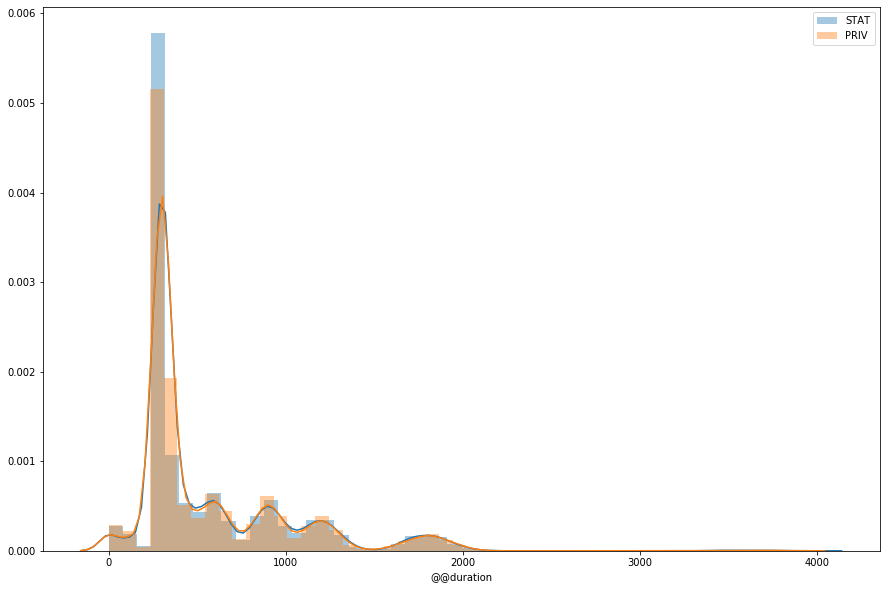

In [36]:
for ins in df_log['Insurance'].unique():
    sns.distplot(df_log[df_log['Insurance'] == ins]['@@duration'], label=ins)

plt.legend()
plt.show()

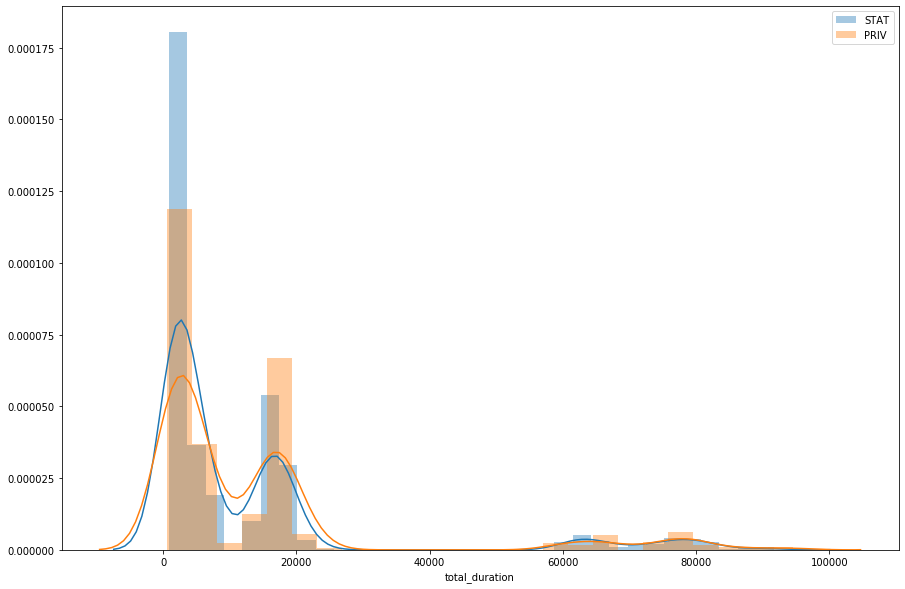

In [37]:
df_['Insurance'] = df_log.groupby('Patient')['Insurance'].first()

for ins in df_['Insurance'].unique():
    sns.distplot(df_[df_['Insurance'] == ins]['total_duration'], label=ins)

plt.legend()
plt.show()

Again, no apparent influence.

In [63]:
case_duration = (df_log.groupby('Patient')['Timestamp'].max() - 
                    df_log.groupby('Patient')['start_timestamp'].min())
case_duration = case_duration.apply(lambda x: x.total_seconds())


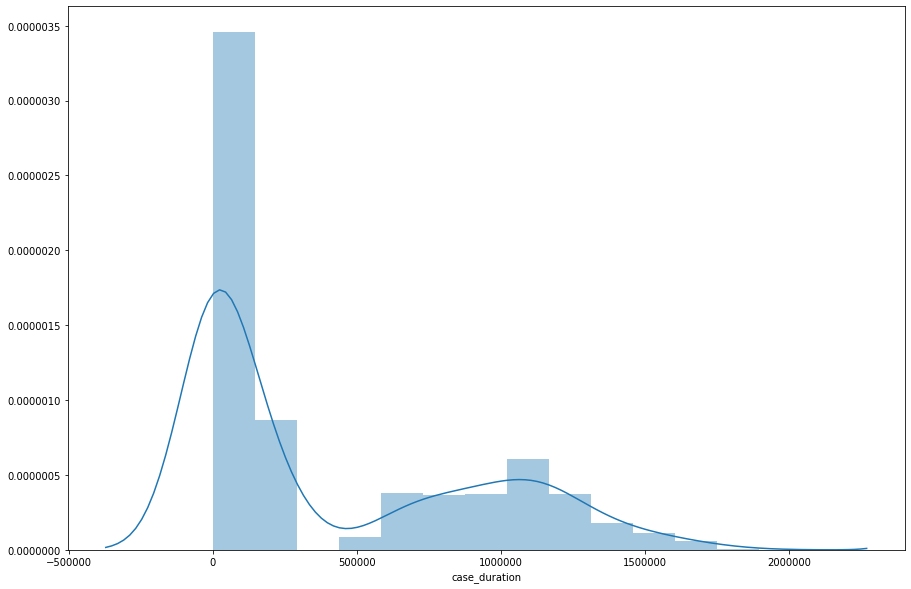

In [108]:
sns.distplot(case_duration)

As we can see there is a group of cases that take substantially longer than the majority of cases we will now focus on this group for further analysis

In [ ]:
new_cc_name = 'Control Call (+)'
split_on_activity = 'Test III'

# get `Test III` moment
df_log_test = df_log[df_log['Activity'] == split_on_activity]
split_timestamp = df_log_test.groupby('Patient')['Timestamp'].first()

# map timestamp to whole patient trace
df_renaming = df_log.copy()
df_renaming[split_on_activity + ' Timestamp'] = df_log['Patient'].map(split_timestamp)

# renames `Control Call` activities that happen after `Test III`
new_cc = df_renaming['Activity'].str.replace('Control Call', new_cc_name)
df_renaming['Activity'] = new_cc.where(
    df_renaming['Timestamp'] > df_renaming[split_on_activity + ' Timestamp'],
    df_renaming['Activity']
)

In [115]:
long_cases = df_renaming.join(case_duration ,on='Patient')
long_cases = long_cases[long_cases['case_duration']>300000]


We can now have a look at the dfg visualisations of the long cases both from a performance and a frequency perspective:

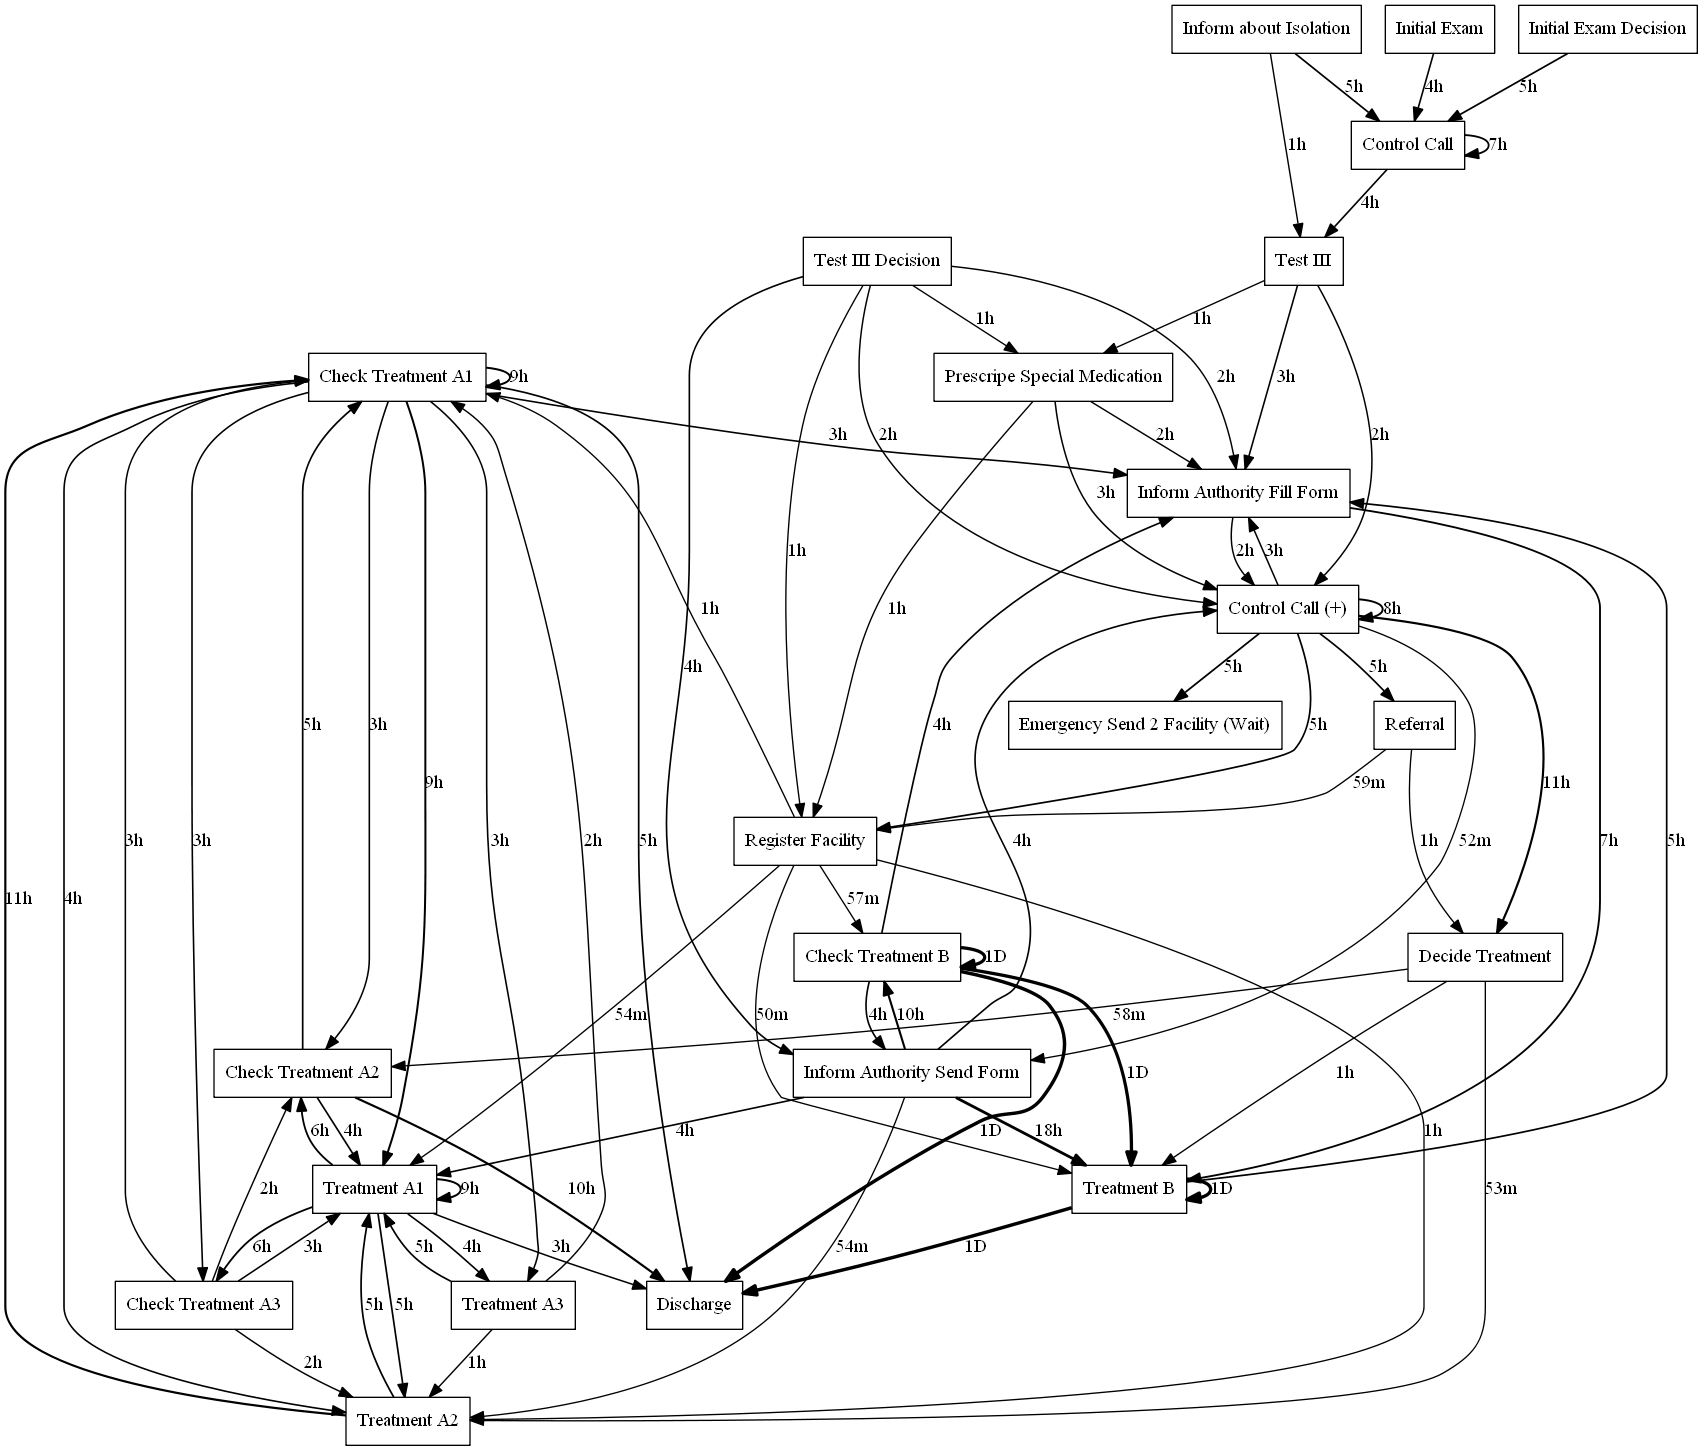

In [122]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualization
from pm4py.objects.conversion.log import converter as log_converter

long_cases_log = log_converter.apply(long_cases, parameters=param_keys)

dfg = dfg_discovery.apply(long_cases_log, variant=dfg_discovery.Variants.PERFORMANCE, parameters=param_keys)
gviz = dfg_visualization.apply(dfg, log=long_cases_log, variant=dfg_visualization.Variants.PERFORMANCE)
dfg_visualization.view(gviz)

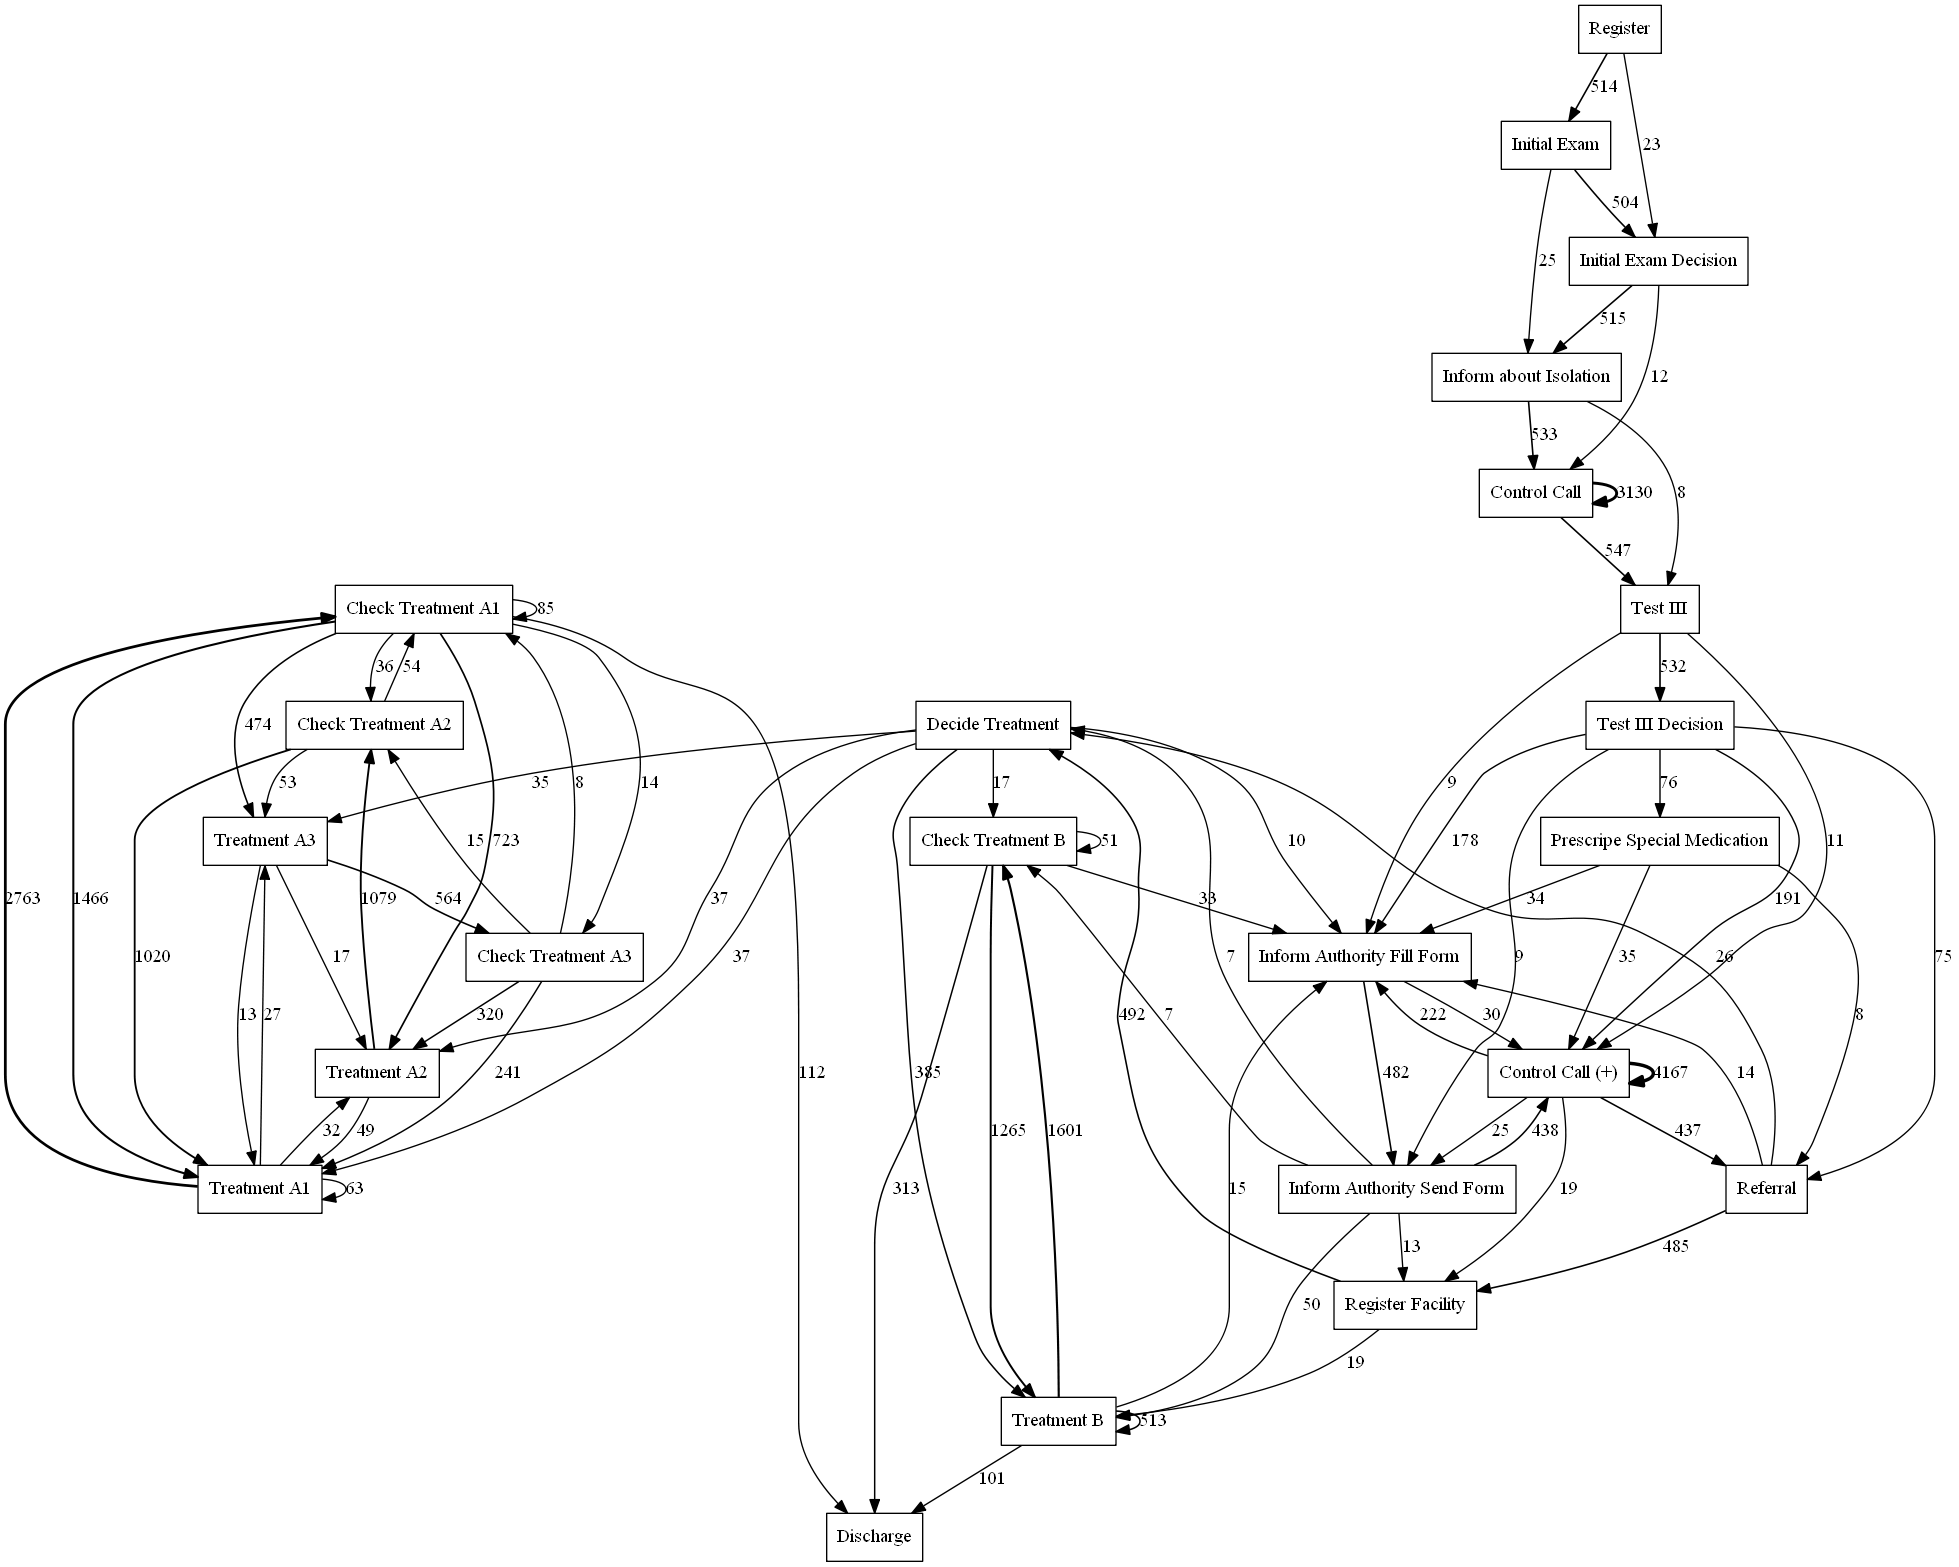

In [124]:
dfg = dfg_discovery.apply(long_cases_log, variant=dfg_discovery.Variants.FREQUENCY, parameters=param_keys)
gviz = dfg_visualization.apply(dfg, log=long_cases_log, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)

When we look at the frequency graph we can see that the control call activities are both very often repeated and have a high mean lead time of 7 or 8 hours. They are a big factor in the long running cases.

In [125]:
print(long_cases['Activity'].value_counts()[:2])
print(df_renaming['Activity'].value_counts()[:2])

Control Call (+)    4872
Control Call        3677
Name: Activity, dtype: int64
Control Call        5082
Control Call (+)    4872
Name: Activity, dtype: int64


A brief comparison of the number of control call activities shows that all control calls after a positive test are still included. This is normal because patients that recive a positive test results will naturally have longer case durations. What is really interesting is that around 72% of the control calls before the test are still included in the long cases. This means that some of the long running cases are caused by patients waiting a long time for a test (and reciving calls while they do).